In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
import zipfile
import os

# Define the path of your zip file and the directory where you want to extract
zip_path = '/content/lfw.zip'
extract_to = '/content/'

# Create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to)

print("Files extracted successfully")

Files extracted successfully


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = './lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")


CUDA device is available. Using GPU: Tesla T4


torch.Size([250, 250, 3])


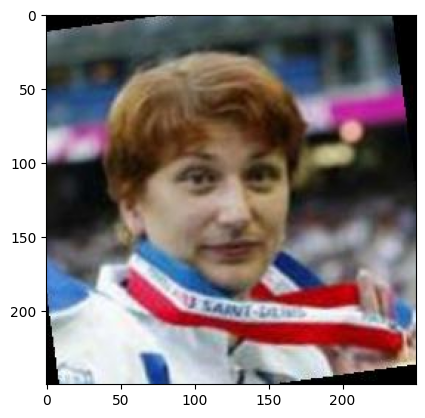

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Autoencoders (AEs) and Variational Autoencoders (VAEs) differ in applications, architecture, and loss functions:

## Applications:
AEs are used for dimensionality reduction, feature learning, and noise reduction. VAEs, on the other hand, are more suited for generative tasks, like creating new data samples similar to the training data.

## Architecture:
Both have encoder-decoder structures, but VAEs add a probabilistic twist. In VAEs, the encoder outputs parameters of a probability distribution (mean and variance), representing the data in a latent space.

## Loss Function:
AE's loss function typically involves reconstruction error, like Mean Squared Error. VAEs add a Kullback-Leibler divergence term to the loss function, encouraging the learned distribution to approximate a prior distribution, usually a Gaussian, enhancing its generative ability.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder convolutional layers
        self.enc_layers = nn.ModuleList([
            nn.Conv2d(3, 32, 4, 2, 1),  # Convolutional layer reducing image size
            nn.Conv2d(32, 64, 4, 2, 1), # Further reducing size and increasing depth
            nn.Conv2d(64, 128, 4, 2, 1),# Continues to extract features and compress
            nn.Conv2d(128, 256, 4, 2, 1)# Final convolution layer
        ])
        # Calculate flat features for linear layer input
        self.calculate_flat_features((3, 250, 250))

        # Linear layers to get latent space parameters
        self.fc_encode = nn.Linear(self._to_linear, 1024)
        self.enc_mu = nn.Linear(1024, 20)     # For mean of latent space
        self.enc_logvar = nn.Linear(1024, 20) # For log variance of latent space

        # Decoder linear and deconvolutional layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.dec_fc = nn.Linear(20, 1024)
        self.dec_to_conv = nn.Linear(1024, 256*16*16)

    def encoder(self, x):
        # Process input through convolutional layers
        for layer in self.enc_layers:
            x = F.relu(layer(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc_encode(x))
        return self.enc_mu(x), self.enc_logvar(x)

    def calculate_flat_features(self, shape):
        # Calculate flattened output size of convolutional layers
        with torch.no_grad():
            x = torch.ones(1, *shape)
            for layer in self.enc_layers:
                x = layer(x)
            self._to_linear = x.view(-1).shape[0]

    def reparameterize(self, mu, logvar):
        # Reparameterization trick for the VAE
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = F.relu(self.dec_fc(z))
        z = F.relu(self.dec_to_conv(z))
        z = z.view(-1, 256, 16, 16)

        # Use transposed convolutions to upsample to the previous layer's spatial dimensions
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))

        # The output should match the input image size, which is [32, 3, 250, 250]
        z = self.deconv4(z)

        # Resize to the correct output size if necessary
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  # Apply sigmoid to scale the pixel values to [0, 1]
        return z

    def forward(self, x):
        # Forward pass through VAE
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


This VAE architecture comprises several key components:

##### 1. Encoder Convolutional Layers:
Compress the input image into a lower-dimensional feature representation. Each layer progressively reduces the spatial dimensions while increasing depth.
##### 2. Flattening and Linear Layers:
After flattening the output of the convolutions, two linear layers generate the mean (mu) and log variance (logvar) for the latent space.
##### 3. Reparameterization:
Applies the reparameterization trick using mu and logvar, creating a sampled latent vector crucial for the VAE's generative process.
##### 4. Decoder Linear and Deconvolutional Layers:
Transform the sampled latent vector back into the spatial dimensions of an image. Deconvolutional layers progressively increase the spatial resolution, reconstructing an image from the latent space.
##### 5. Forward Pass:
Orchestrates the process, passing input through the encoder, reparameterizing, and then reconstructing it via the decoder.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [9]:
# Create an instance of the VAE model and transfer it to the appropriate device (GPU/CPU)
model = VAE().to(device)

# Load a batch of images from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Pass a single image through the model without computing gradients (for efficiency)
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    # Process the first image in the batch through the encoder
    mu, logvar = model.encoder(images[0].unsqueeze(0))
    print("Encoders Output Shape - mu :", mu.shape)
    print("Encoders Output Shape - logvar:", logvar.shape)

    # Reparameterize to get latent samples and pass them through the decoder
    samples = model.reparameterize(mu, logvar)
    print("Sample Output Shape in latent space:", samples.shape)
    generated_images = model.decoder(samples)
    print("Decoders Output Shape:", generated_images.shape)


Encoders Output Shape - mu : torch.Size([1, 20])
Encoders Output Shape - logvar: torch.Size([1, 20])
Sample Output Shape in latent space: torch.Size([1, 20])
Decoders Output Shape: torch.Size([1, 3, 250, 250])


Generating new samples in the latent space of a Variational Autoencoder (VAE) involves the following steps:

#### Encoding:
First, an image (or batch of images) is passed through the VAE's encoder. The encoder, consisting of convolutional layers, compresses the image into a lower-dimensional latent space, producing two vectors: mean (mu) and log variance (logvar).
#### Reparameterization Trick:
This step is crucial for generating new samples. The mean and log variance are used to create a distribution from which we can sample. The log variance is exponentiated and square-rooted (to get the standard deviation), and a random value (epsilon) is sampled from a standard normal distribution. This random value is scaled by the standard deviation and added to the mean, resulting in a new sample point in the latent space.
#### Decoding:
This new sample in the latent space is then passed through the decoder, which reconstructs it back into the original data space. The decoder, typically comprising transposed convolutional layers, transforms the latent sample back into an image.


This process allows the VAE to generate new data points (images) that resemble the original dataset, as the latent space captures the essential features and variations present in the data.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [10]:
model = VAE().to(device)  # Assuming VAE is your model class

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)


Total number of trainable parameters: 127600363


In [11]:
# Define the optimizer using Adam algorithm with a learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    # Binary Cross-Entropy loss: Compares the reconstructed image (recon_x) with the original image (x)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Kullback-Leibler divergence: Measures how the distribution parameterized by the encoder
    # (mu, logvar) diverges from a standard normal distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is the sum of BCE and KLD
    return BCE + KLD


In a Variational Autoencoder (VAE), the loss function typically comprises two parts: the reconstruction loss and the Kullback-Leibler (KL) divergence.

* Reconstruction Loss:
This part of the loss measures how well the decoded samples match the original inputs. It's often calculated using the Binary Cross-Entropy (BCE) between the original image and the reconstructed image from the decoder.
* KL Divergence:
This part of the loss ensures that the learned latent space distribution (represented by mu and logvar) approximates the prior distribution (typically a standard normal distribution). It acts as a regularizer on the latent space.

The total loss is the sum of these two components. This combination helps the VAE not only to reconstruct the input data accurately but also to learn a meaningful and well-structured latent space.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [12]:
epochs = 10
# Training loop for a specified number of epochs
for epoch in range(1, epochs + 1):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize loss for this epoch
    for batch_idx, (data, _) in enumerate(dataloader):  # Iterate over batches
        data = data.to(device)  # Move data to the device
        optimizer.zero_grad()  # Reset gradients
        recon_batch, mu, logvar = model(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Compute loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()  # Accumulate the loss
        optimizer.step()  # Update weights

    average_loss = train_loss / len(dataloader.dataset)  # Calculate average loss
    print(f'Epoch: {epoch} Average Loss: {average_loss:.4f}')  # Print average loss for the epoch

# Generate and visualize new images from the latent space
with torch.no_grad():  # Disable gradient tracking
    sample = torch.randn(64, 20).to(device)  # Generate random latent vectors
    sample = model.decoder(sample).cpu()  # Decode the latent vectors to images
    # Visualization code should be added here to display the images


Epoch: 1 Average Loss: 107259.5881
Epoch: 2 Average Loss: 98608.8888
Epoch: 3 Average Loss: 97500.4736
Epoch: 4 Average Loss: 97071.5820
Epoch: 5 Average Loss: 96796.1849
Epoch: 6 Average Loss: 96566.9933
Epoch: 7 Average Loss: 96343.1888
Epoch: 8 Average Loss: 96085.2137
Epoch: 9 Average Loss: 95714.5191
Epoch: 10 Average Loss: 95464.0429


If our loss is not decreasing during training, consider these troubleshooting steps:

Learning Rate Adjustment: If the learning rate is too high, the model might overshoot minima. Try reducing it. Conversely, if it's too low, training may be too slow.

Check Data and Preprocessing: Ensure data is correctly preprocessed and normalized. Incorrect data processing can adversely affect training.

Model Complexity: Review if your model is too complex or too simple for the task. Simplify the model if it's overfitting or make it more complex if it's underfitting.

Regularization Techniques: Implement dropout layers or weight decay to prevent overfitting.

Batch Size: Experiment with different batch sizes. Sometimes smaller or larger batches can impact the learning process.

Optimizer: Experiment with different optimizers (like SGD, Adam) and their settings.

Review Loss Function: Make sure the loss function is suitable for your specific problem.

Early Stopping: Implement early stopping to prevent overfitting.

Check for Errors: Look for bugs in your code that might affect the loss calculation or data feeding.
Monitor Gradients: Check if gradients are vanishing or exploding, and apply techniques like gradient clipping if necessary.

However, loss is decreasing in our case

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

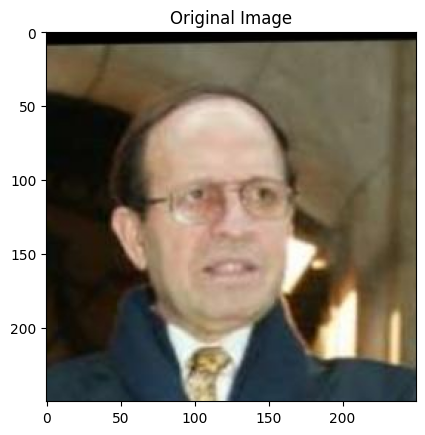

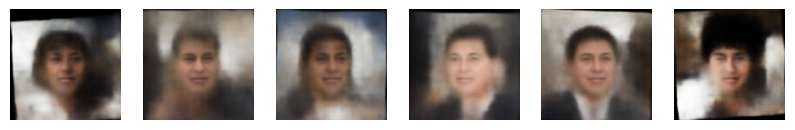

In [16]:
import matplotlib.pyplot as plt

# After training
model.eval()

# Take a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader)):
            original_image = data[0].to(device)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.show()
            break

# Generate new samples and plot them
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    generated_images = model.decoder(sample).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 2))
    for ax, img in zip(axes.flat, generated_images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.show()